# **Edge-Centric Model Training**

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
print(f"{'torch:':<20} {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{'device:':<20} {device}")

import numpy as np
import math
import random
print(f"{'numpy:':<20} {np.__version__}")

import matplotlib
import matplotlib.pyplot as plt
print(f"{'matplotlib:':<20} {matplotlib.__version__}")

from tqdm import tqdm

import logger
print(f"{'logger (custom):':<20} loaded")

from Models.Architectures.edgeGNN import EdgeCentricNetwork
from DataManagement.data import StaticFinancialDataset, TemporalFinancialDataset

torch:               2.7.1+cu118
device:              cuda
numpy:               2.2.4
matplotlib:          3.10.3
logger (custom):     loaded


In [2]:
window = 14
dataset = TemporalFinancialDataset(window_size=window)

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1254 rows with data
XLF: 1254 rows with data
XLE: 1254 rows with data
XLV: 1254 rows with data
XLI: 1254 rows with data
XLP: 1254 rows with data
XLY: 1254 rows with data
XLU: 1254 rows with data
XLB: 1254 rows with data
XLRE: 1254 rows with data
XLC: 1254 rows with data
✓ All sectors have same number of dates
Common dates: 1254
XLK len: 1254
XLF len: 1254
XLE len: 1254
XLV len: 1254
XLI len: 1254
XLP len: 1254
XLY len: 1254
XLU len: 1254
XLB len: 1254
XLRE len: 1254
XLC len: 12

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data.py:146: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  feature_data = torch.tensor(data=feature_data, dtype=torch.float32).transpose(0, 1)


In [3]:
num_samples = len(dataset)

train_split = 0.8
test_split = 0.2

train_size = int(train_split * num_samples)
test_size = num_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
test_dataset = torch.utils.data.Subset(dataset, list(range(train_size, num_samples)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

sample_batch = next(iter(train_loader))
print(f"Batch Feature Dim: {sample_batch[0].shape}")
print(f"Batch Target Dim: {sample_batch[1].shape}")
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

print(dataset.features.shape)

Batch Feature Dim: torch.Size([64, 14, 11, 89])
Batch Target Dim: torch.Size([64, 14, 11])
Train Dataset Length: 968
Test Dataset Length: 242
torch.Size([1223, 11, 89])


In [4]:
static = False
temporal = True
model = EdgeCentricNetwork(num_nodes=dataset.num_sectors, edge_dim=10, node_dim=dataset.features.shape[2], static=static, temporal=temporal, window=window)
model.to(device)

LR = 3.5e-5
optimizer = optim.Adam(params=model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

model

EdgeCentricNetwork(
  (edge_updater): TemporalEdgeUpdater(
    (sigmoid): Sigmoid()
    (tanh): Tanh()
    (lstm_layers): ModuleList(
      (0): LSTM(178, 128, batch_first=True)
      (1): LSTM(128, 64, batch_first=True)
      (2): LSTM(64, 32, batch_first=True)
    )
    (refined_edges): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=10, bias=True)
    )
  )
  (regression): EdgetoNodeRegressionBlock(
    (regression): Sequential(
      (0): Linear(in_features=110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)

In [7]:
epoch_num = 1500

epoch_losses = []
batch_losses = []

model.train()
for epoch in range(epoch_num):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epoch_num}]", leave=False)

    for features, targets in train_loader:
        features = features.to(device)
        targets = targets.unsqueeze(2).to(device)

        optimizer.zero_grad()

        output = model(features)
        
        loss = criterion(output, targets)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_losses.append(epoch_loss / len(train_loader))
    if epoch % 20 == 0:
        print(f"Epoch [{epoch+1}/{epoch_num}] Loss: {epoch_losses[-1]:.6f}")

Epoch [1/1500]:   0%|          | 0/16 [00:02<?, ?it/s, loss=0.0467]

Epoch [1/1500] Loss: 0.037066


Epoch [21/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0468]

Epoch [21/1500] Loss: 0.036953


Epoch [41/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0467]

Epoch [41/1500] Loss: 0.036877


Epoch [61/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0465]

Epoch [61/1500] Loss: 0.036826


Epoch [81/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0462]

Epoch [81/1500] Loss: 0.036682


Epoch [101/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0458]

Epoch [101/1500] Loss: 0.036566


Epoch [121/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0455]

Epoch [121/1500] Loss: 0.036540


Epoch [141/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0452]

Epoch [141/1500] Loss: 0.036362


Epoch [161/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0447]

Epoch [161/1500] Loss: 0.036342


Epoch [181/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0441]

Epoch [181/1500] Loss: 0.036083


Epoch [201/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0437]

Epoch [201/1500] Loss: 0.036015


Epoch [221/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0432]

Epoch [221/1500] Loss: 0.035789


Epoch [241/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.043] 

Epoch [241/1500] Loss: 0.035931


Epoch [261/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0416]

Epoch [261/1500] Loss: 0.035356


Epoch [281/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0415]

Epoch [281/1500] Loss: 0.035324


Epoch [301/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0415]

Epoch [301/1500] Loss: 0.035558


Epoch [321/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0399]

Epoch [321/1500] Loss: 0.035020


Epoch [341/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0388]

Epoch [341/1500] Loss: 0.034724


Epoch [361/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0382]

Epoch [361/1500] Loss: 0.034270


Epoch [381/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0383]

Epoch [381/1500] Loss: 0.034274


Epoch [401/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0372]

Epoch [401/1500] Loss: 0.033581


Epoch [421/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0377]

Epoch [421/1500] Loss: 0.033331


Epoch [441/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0386]

Epoch [441/1500] Loss: 0.033741


Epoch [461/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0362]

Epoch [461/1500] Loss: 0.032975


Epoch [481/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.036] 

Epoch [481/1500] Loss: 0.032938


Epoch [501/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0363]

Epoch [501/1500] Loss: 0.032932


Epoch [521/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0365]

Epoch [521/1500] Loss: 0.033154


Epoch [541/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0362]

Epoch [541/1500] Loss: 0.032137


Epoch [561/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0359]

Epoch [561/1500] Loss: 0.031532


Epoch [581/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0358]

Epoch [581/1500] Loss: 0.031164


Epoch [601/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0364]

Epoch [601/1500] Loss: 0.032116


Epoch [621/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0357]

Epoch [621/1500] Loss: 0.030883


Epoch [641/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0357]

Epoch [641/1500] Loss: 0.030433


Epoch [661/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0363]

Epoch [661/1500] Loss: 0.032329


Epoch [681/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0357]

Epoch [681/1500] Loss: 0.030393


Epoch [701/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0365]

Epoch [701/1500] Loss: 0.031407


Epoch [721/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.036] 

Epoch [721/1500] Loss: 0.030906


Epoch [741/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0356]

Epoch [741/1500] Loss: 0.030144


Epoch [761/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0353]

Epoch [761/1500] Loss: 0.029773


Epoch [781/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0353]

Epoch [781/1500] Loss: 0.029504


Epoch [801/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0355]

Epoch [801/1500] Loss: 0.029899


Epoch [821/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.035] 

Epoch [821/1500] Loss: 0.029511


Epoch [841/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0348]

Epoch [841/1500] Loss: 0.029154


Epoch [861/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0356]

Epoch [861/1500] Loss: 0.030247


Epoch [881/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0349]

Epoch [881/1500] Loss: 0.029368


Epoch [901/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0348]

Epoch [901/1500] Loss: 0.028764


Epoch [921/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.035] 

Epoch [921/1500] Loss: 0.028643


Epoch [941/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0351]

Epoch [941/1500] Loss: 0.029567


Epoch [961/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.035] 

Epoch [961/1500] Loss: 0.029339


Epoch [981/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0347]

Epoch [981/1500] Loss: 0.028856


Epoch [1001/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0346]

Epoch [1001/1500] Loss: 0.028905


Epoch [1021/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0346]

Epoch [1021/1500] Loss: 0.028003


Epoch [1041/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0346]

Epoch [1041/1500] Loss: 0.027875


Epoch [1061/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0344]

Epoch [1061/1500] Loss: 0.027651


Epoch [1081/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0347]

Epoch [1081/1500] Loss: 0.027822


Epoch [1101/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0349]

Epoch [1101/1500] Loss: 0.028114


Epoch [1121/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0345]

Epoch [1121/1500] Loss: 0.027744


Epoch [1141/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0348]

Epoch [1141/1500] Loss: 0.028372


Epoch [1161/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0344]

Epoch [1161/1500] Loss: 0.027386


Epoch [1181/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0346]

Epoch [1181/1500] Loss: 0.027901


Epoch [1201/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0354]

Epoch [1201/1500] Loss: 0.028465


Epoch [1221/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0346]

Epoch [1221/1500] Loss: 0.027873


Epoch [1241/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0343]

Epoch [1241/1500] Loss: 0.027143


Epoch [1261/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0343]

Epoch [1261/1500] Loss: 0.027190


Epoch [1281/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0343]

Epoch [1281/1500] Loss: 0.027125


Epoch [1301/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0347]

Epoch [1301/1500] Loss: 0.027778


Epoch [1321/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0344]

Epoch [1321/1500] Loss: 0.026967


Epoch [1341/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0342]

Epoch [1341/1500] Loss: 0.026738


Epoch [1361/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0344]

Epoch [1361/1500] Loss: 0.027158


Epoch [1381/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0346]

Epoch [1381/1500] Loss: 0.027298


Epoch [1401/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0362]

Epoch [1401/1500] Loss: 0.029490


Epoch [1421/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0352]

Epoch [1421/1500] Loss: 0.027900


Epoch [1441/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0347]

Epoch [1441/1500] Loss: 0.027457


Epoch [1461/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0344]

Epoch [1461/1500] Loss: 0.026883


Epoch [1481/1500]:   0%|          | 0/16 [00:03<?, ?it/s, loss=0.0343]

Epoch [1481/1500] Loss: 0.026976


In [21]:
# Inference
model.eval()

test_loss = 0.0
test_losses = []
outputs = []
truths = []

for features, targets in test_loader:

    features = features.to(device)
    targets = targets.to(device).unsqueeze(3)
    output = model(features).squeeze(2)
  
    outputs.append(output.cpu().flatten())
    truths.append(targets.cpu().flatten())

    #print(f"Target Shape: {targets.shape}")
    #print(f"Output Shape: {outputs.shape}")
    loss = criterion(output, targets)
    
    test_losses.append(loss.item())

    test_loss += loss.item()

print(f"Total Test Loss: {test_loss}")

all_outputs = torch.cat(outputs).detach().numpy()
all_truths = torch.cat(truths).detach().numpy()

print(f"All Outputs Shape: {all_outputs.shape}")
print(f"All Truths Shape: {all_truths.shape}")

Total Test Loss: 0.19986195862293243
All Outputs Shape: (37268,)
All Truths Shape: (37268,)


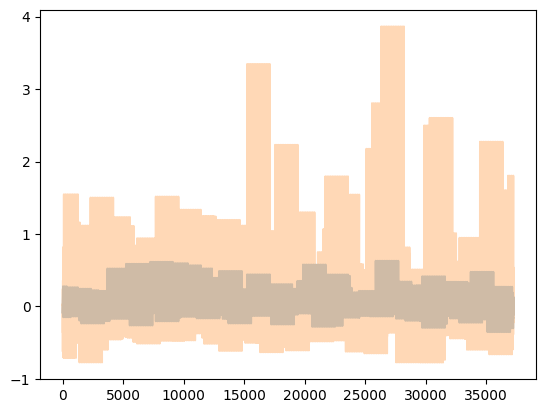

In [26]:
x = np.linspace(start=0, stop=all_outputs.shape[0], num=all_outputs.shape[0])
plt.plot(x, all_outputs, alpha=0.3)
plt.plot(x, all_truths, alpha=0.3)

In [27]:
# Fun Statistic Checker Code 

count_bound = 0
count_no_bound = 0

within_bounds_outputs = []
within_bounds_truths = []

max_truth, min_truth = np.max(all_truths), np.min(all_truths)
print(f"Max Truth Val: {max_truth}")
print(f"Min Truth Val: {min_truth}")

for idx, pred in enumerate(all_outputs):
    if pred >= -1 and pred <= 1 and all_truths[idx] >= -1 and all_truths[idx] <= 1:
        count_bound += 1
        within_bounds_outputs.append(all_outputs[idx])
        within_bounds_truths.append(all_truths[idx])
    else:
        count_no_bound+=1

print(f"Within Bound -1 to 1: {count_bound}")
print(f"Outside of -1 to 1: {count_no_bound}")

Max Truth Val: 3.8637616634368896
Min Truth Val: -0.7724792957305908
Within Bound -1 to 1: 36687
Outside of -1 to 1: 581


C:\Users\lordw\AppData\Local\Temp\ipykernel_69104\380006448.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


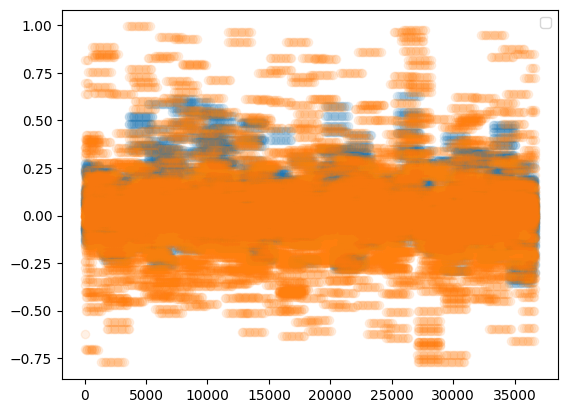

In [30]:
x = np.linspace(start=0, stop=len(within_bounds_outputs) - 1, num=len(within_bounds_outputs))

plt.scatter(x, within_bounds_outputs, alpha=0.1)
#plt.scatter(x, all_truths, alpha=0.05)
plt.scatter(x, within_bounds_truths, alpha=0.1)

plt.legend()

In [ ]:
# Model Save lol forgot this before
torch.save(model.state_dict(), "Models/save/TemporalEdgeCentricGNN_state.pth")
torch.save(model, "Models/save/TemporalEdgeCentricGNN_full.pth")